### Pictoral Holography

Now lets try something other than spots, like a picture. Our Fourier calibration can do more than targeting certain blazes. We can request an image in the `"ij"` basis, and the Fourier calibration will convert that image to a target in the computational SLM farfield basis for optimization.

In [163]:
# Header. This is hidden from sphinx with the json metadata:
#   {"nbsphinx":"hidden"}

# ipython configuration (reloads source code automatically and plots inline)
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os, sys, time
import numpy as np
import cv2
import scipy.ndimage as ndimage

import warnings
warnings.filterwarnings("ignore")

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('image', cmap='Blues')

# Add slmsuite to the python path. TODO: Remove and replace with package import
sys.path.append(os.path.join(os.getcwd(), '../../../..'))

from slmsuite.holography import analysis, toolbox
from slmsuite.hardware.slms.santec import Santec
from slmsuite.hardware.cameras import AlliedVision
from slmsuite.hardware.cameraslms import FourierSLM
from slmsuite.holography.algorithms import FeedbackHologram, SpotHologram

santec.py: Santec DLLs not installed. Install these to use Santec SLMs.
  Dynamically linked libraries from Santec (usually provided via USB) must be present in the slms directory:
  - SLMFunc.dll
  - FTD3XX.dll
  You can find the slms directory at '/Users/i/Documents/GitHub/slmsuite/slmsuite/hardware/slms'
  Check that theses files are present and are error-free.
Original error: _type_ 'v' not supported
cupy not installed. Using numpy.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
slm = Santec(slm_number=1, display_number=2, wav_um=.633); print()
cam = AlliedVision(serial="02C5V", verbose=True, fliplr=True)
fs = FourierSLM(cam, slm)

In [ ]:
cam.set_exposure(5e-3)
fs.fourier_calibrate(array_shape=[60, 40], array_pitch=[15, 20])
cam.set_exposure(5e-4)

### Pictoral Holography



In [164]:
path = os.path.join(os.getcwd(), '../../../source/static/qp-slm-small.png')
paths = [path for _ in range(10)]

In [165]:
shape = (1200, 1600)

def load_img(path, target_shape=None, angle=0, shift=(-200, 0), plot=False):
    # Load the image.
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    if img is None:
        raise ValueError("Image not found at path '{}'".format(path))

    # Invert if necessary such that the majority of the image is dark.
    if np.mean(img) > np.mean(cv2.bitwise_not(img)):
        img = cv2.bitwise_not(img)

    if angle != 0:
        img = ndimage.rotate(img, angle)

    if target_shape is not None:
        zoom_x = target_shape[0] / img.shape[0]
        zoom_y = target_shape[1] / img.shape[1]
        img = ndimage.zoom(img, min(zoom_x, zoom_y))

    # sqrt to get the amplitude.
    target_ij = toolbox.pad(analysis._make_8bit(np.sqrt(img)), shape) # fs.cam.shape)

    # Shift to the desired center.
    target_ij = np.roll(target_ij, shift, axis=(0,1))

    if plot:
        plot_img(target_ij)
        plt.show()

    return target_ij

def plot_img(target_ij):
    # Plot the desired camera space.
    plt.figure(figsize=(16,12))
    plt.imshow(target_ij)
    plt.plot(target_ij.shape[1]/2, target_ij.shape[0]/2, 'r*')

# load_img(path, (250,250), plot=True);

In [177]:
def load_composite_img(paths, plot=True):
    N = len(paths)

    result = toolbox.lloyds_points(shape, N, iterations=50, plot=False)
    toolbox.voronoi_windows(shape, result, plot=True)
    max_size = toolbox.smallest_distance(result)
    final = None

    for index, path in enumerate(paths):
        img = load_img(
            path, 
            target_shape=(max_size, max_size), 
            shift=(int(result[1, index] - shape[0]/2), int(result[0, index] - shape[1]/2))
        )

        if final is None:
            final = img
        else:
            final += img

    plot_img(final)

    # for index, path in enumerate(paths):
    #     plt.annotate(path,
    #         (int(result[1, index] - shape[0]/2), int(result[0, index] - shape[1]/2)),
    #         c="r", size="x-small", ha="center")

    plt.show()

    return final

['logos/qp-slm.png', 'logos/Santec.png', 'logos/MIT.png']


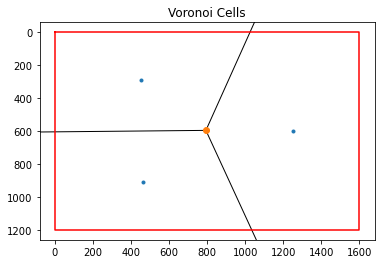

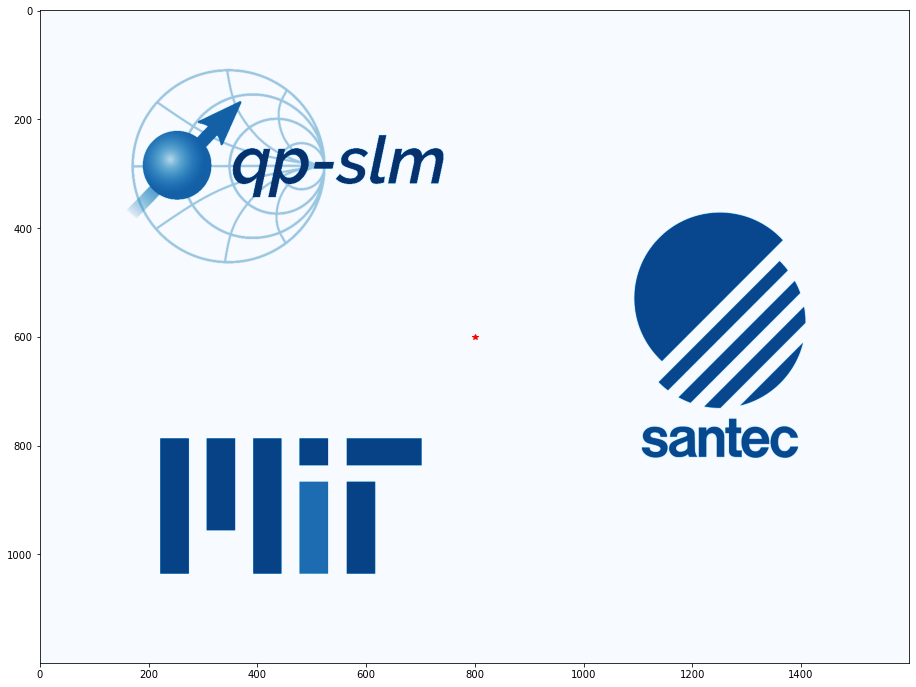

In [178]:
folder = 'logos'
paths = [os.path.join(folder, path) for path in os.listdir(folder)]
paths = [path for path in paths if cv2.imread(path, cv2.IMREAD_GRAYSCALE) is not None]
print(paths)

img = load_composite_img(paths, plot=True)

827 ms ± 30.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


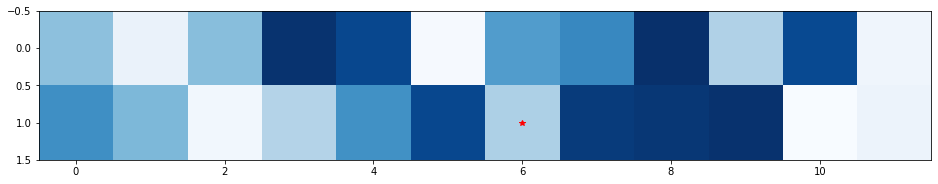

In [205]:
from slmsuite.holography.algorithms import _adaptive_gaussian_filter

noise = np.random.random(img.shape)
mask = img / np.max(img)

# plot_img(mask)
# plot_img(noise)
result = _adaptive_gaussian_filter(img=noise, mask=mask, sigma=2)

plot_img(result)

Quickly, we'll make some variables to help record and interpret our results:

In [ ]:
original_shape = img_amp.shape
target_shape = fs.cam.shape
p = 10

cxi = int(-original_shape[1]/2 + target_shape[1]/2 + shift[0] - p)
cxf = int( original_shape[1]/2 + target_shape[1]/2 + shift[0] + p)
cyi = int(-original_shape[0]/2 + target_shape[0]/2 + shift[1] - p)
cyf = int( original_shape[0]/2 + target_shape[0]/2 + shift[1] + p)

final_images = {}
final_images["Target"] = target_ij[cyi:cyf, cxi:cxf]

Now we can look to optimize the SLM phase to produce this desired pattern. Starting without feedback, we try optimization using unweighted GS. Plotted below with our helper function `plot_data` is the result of optimization measured experimentally by our camera, along with the GS weights (See API) that was used during optimization. For unweighted GS, these weights are unchanged from the target, which is just a rotated and stretched version of our desired image.

In [ ]:
def plot_data(title=' Computational'):
    fs.slm.write(hologram.extract_phase(), wait_for_settle=True)

    img = fs.cam.get_image()

    limits = [[ 963, 1079], [763, 844]]

    hologram.plot_farfield(hologram.ijcam_to_knmslm(img), limits=limits, title='Exp. Result' + title)
    hologram.plot_farfield(hologram.weights, limits=limits, title='Weights' + title)

hologram = FeedbackHologram(shape=shape, target_ij=target_ij, cameraslm=fs)

hologram.optimize(method="GS", maxiter=20, feedback='computational', stat_groups=['computational'])
plot_data(title=' Computational GS')

img = fs.cam.get_image()
final_images["GS"] = img[cyi:cyf, cxi:cxf]

Now if we try weighted GS, we'll see that the weights change according to the internal computational result, but the experimental result isn't too much better.

In [ ]:
# Renew hologram
hologram = FeedbackHologram(shape=shape, target_ij=target_ij, cameraslm=fs)

# Computational WGS refinement
hologram.optimize(method="WGS-Kim", maxiter=20, feedback='computational', stat_groups=['computational'])
plot_data(title=' Computational WGS')

img = fs.cam.get_image()
final_images["WGS-Computational"] = img[cyi:cyf, cxi:cxf]

With experimental feedback on the weights, however, we observe a clear improvement, where edges become significantly crisper.

In [ ]:
# Experimental WGS refinement
hologram.optimize(  method="WGS-Kim", maxiter=20, feedback='experimental', 
                    stat_groups=['computational', 'experimental'], blur_ij=1)
plot_data(title=' Experimental WGS')

img = fs.cam.get_image()
final_images["WGS-Experimental"] = img[cyi:cyf, cxi:cxf]

We lastly compare the target with these three results to demonstrate the usefulness of Fourier calibration and automated feedback for refining excellent holograms.

In [ ]:
# Get the mean power in all the image such that we can make a more direct comparison.
maxes = []

for x, key in enumerate(final_images.keys()):
    final_images[key] = final_images[key].astype(np.float64)
    final_images[key] *= 1/np.mean(final_images[key])
    maxes.append(np.amax(final_images[key]))

# Choose a clim which slightly saturates the images.
max = np.max(maxes) * .75

# Plot the images.
fig, axs = plt.subplots(4, 1, figsize=(20,20))

for x, key in enumerate(final_images.keys()):
    axs[x].imshow(final_images[key], vmin=0, vmax=max)
    axs[x].set_title(key)
    axs[x].xaxis.set_visible(False)
    axs[x].yaxis.set_visible(False)

### Spot Holography

In [ ]:
spots = toolbox.lloyds_points(grid=(240, 320), n_points=100, iterations=25); spots[0, :] += 500; spots[1, :] += 200

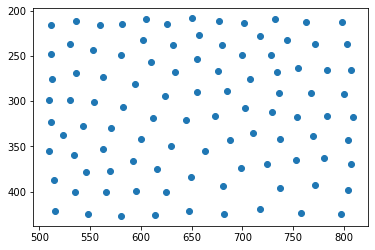

In [ ]:
plt.scatter(spots[0, :], spots[1, :])
plt.gca().set_ylim(np.flip(plt.gca().get_ylim()))
plt.show()

In [ ]:
hologram = SpotHologram(shape=(2048, 2048), spot_vectors=spots, basis="ij", cameraslm=fs)

100%|██████████| 20/20 [00:00<00:00, 36.13it/s]


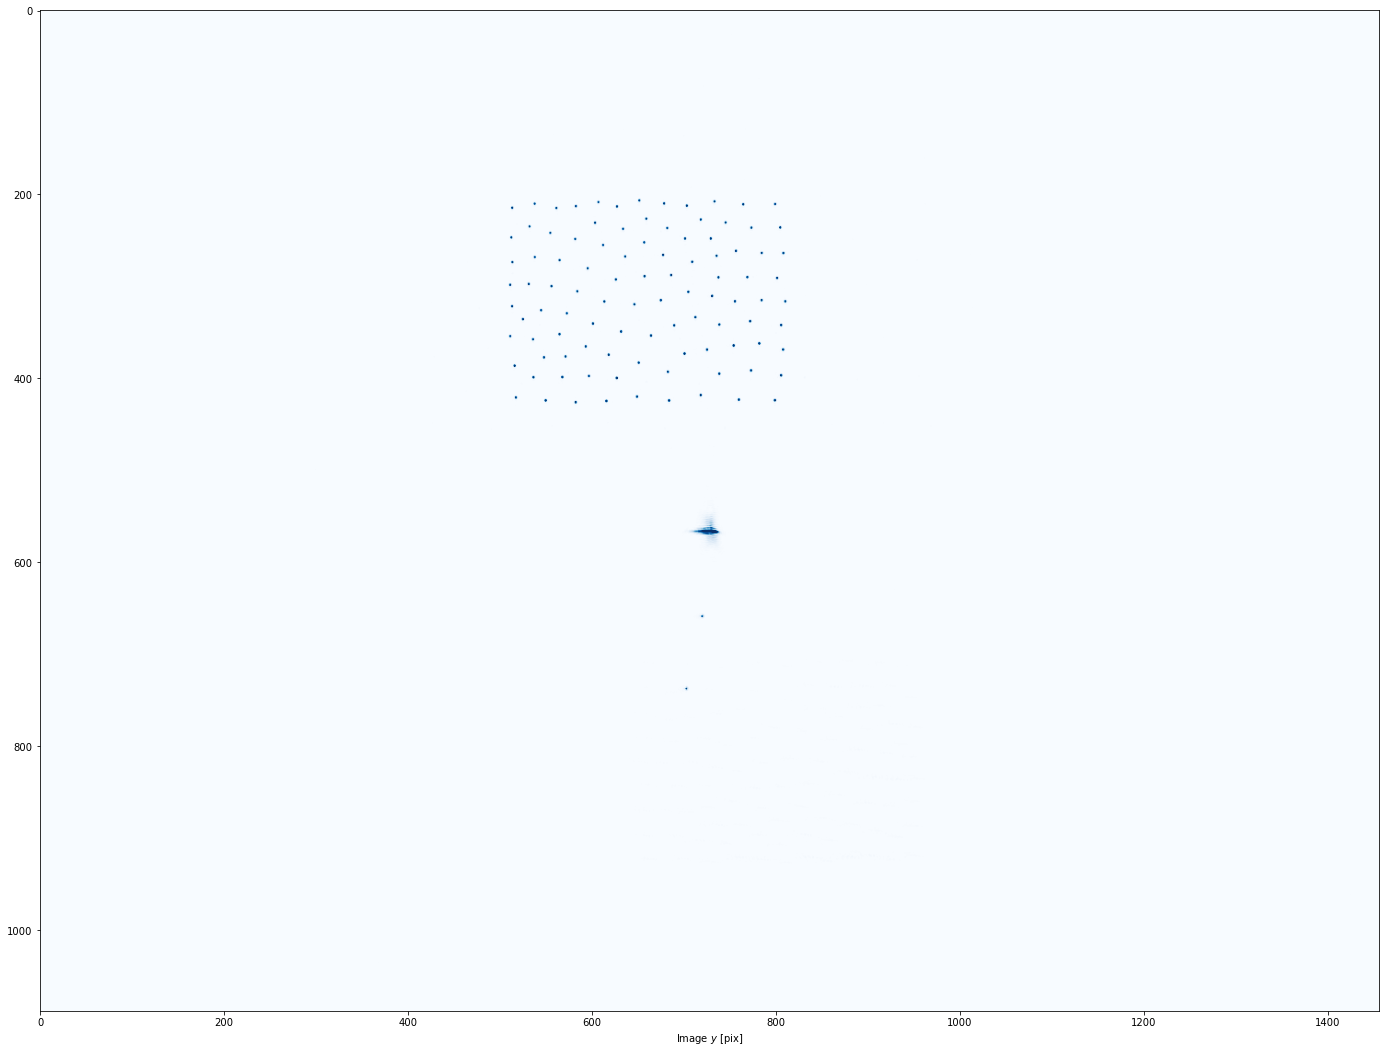

In [ ]:
imgs = {}
cam.set_exposure(.01)
hologram.optimize(method="GS", maxiter=20, feedback='computational', stat_groups=['computational'])

fs.slm.write(hologram.extract_phase(), settle=True)
fs.cam.set_exposure(.001)
img = fs.cam.get_image()

plt.figure(figsize=(24,24))
plt.imshow(img)
plt.xlabel("Image $x$ [pix]"); plt.xlabel("Image $y$ [pix]")
plt.show()

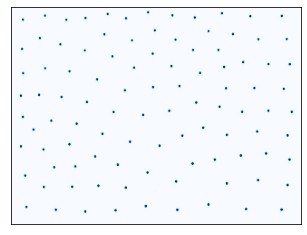

In [ ]:
# Make a plot for the thumbnail.
plt.imshow(img[200:440, 500:820])
plt.xticks([])
plt.yticks([])
plt.show()